In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [ ]:
from nbdev import *
%nbdev_default_export training

Cells will be exported to srthesis.training,
unless a different module is specified after an export flag: `%nbdev_export special.module`


In [ ]:
from srthesis.utils import *
select_gpu()

GPUs:2
Selected GPU:1
Available memory:11016MB


# Generator pretraining



In [ ]:
%nbdev_export_internal
import json
import shutil
import re
import os
import psutil

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

import torch
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

from srthesis.data_realsr import *
from srthesis.data import *

from srthesis.loss import *
from srthesis.metrics import *
from srthesis.callbacks import *
from srthesis.model import *



Setting up Perceptual loss...
Loading model from: /home/luslad/thesis/PerceptualSimilarity/models/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


## Config and cleanup

In [ ]:
run_id = 'test'
group_id = 'tests'

In [ ]:
%nbdev_export_internal
import os
def get_config(run_id, group_id='default'):
    
    path_logging = Path('results/logging/') / group_id / run_id
    path_tensorboard = Path('results/tensorboard/' + group_id)
    path_images = Path('results/images/') / group_id / run_id
    
    path_images.mkdir(parents = True, exist_ok = True)
    
    return path_logging, path_tensorboard, path_images



In [ ]:
%nbdev_export
class RunInfo:
    group_id:str
    run_id:str
    path_logging:Path
    path_tensorboard:Path
    path_images:Path
        
    dataset='realsr' 
    total_iters = 5e5
    repeat_train = 5000
    loss_type='feature'
    pretraining=True
    dihedral_augs=True
    max_train_len = 1
    train_include:List[str]=[]
    start_epoch=0
    random_seed=42
    
    #logging
    visual_iters = 5000,
    loss_iters = 100,
    checkpoint_every = 50000,
        
    def __init__(self, 
                 group_id, run_id, 
                 dataset='realsr',
                 total_iters=5e5,
                 repeat_train=1,
                 max_train_len:int=sys.maxsize,
                 train_include=[],
                 loss_type='feature',
                 pretraining:bool=False,
                 dihedral_augs:bool=True,
                 start_epoch=0,
                 random_seed=42,
                 visual_iters=10000,
                 loss_iters=1000,
                 checkpoint_every=50000):
        self.group_id, self.run_id = group_id, run_id
        self.path_logging, self.path_tensorboard, self.path_images = get_config(run_id, group_id)
        self.dataset = dataset
        self.total_iters = total_iters
        self.repeat_train = repeat_train
        self.loss_type = loss_type
        self.pretraining = pretraining
        self.dihedral_augs = dihedral_augs
        self.start_epoch = start_epoch
        self.max_train_len = max_train_len
        self.train_include = train_include
        self.random_seed = random_seed
        self.visual_iters = visual_iters
        self.loss_iters = loss_iters
        self.checkpoint_every = checkpoint_every
        
        #with open(self.path_logging / 'model_info.json', 'w') as outfile:
        #    json.dump(vars(self), outfile)
        
    def get_paths(self):
        return self.path_logging, self.path_tensorboard, self.path_images
    
    def cleanup(self):
        def _delete_log_dir(path:str):
            shutil.rmtree(path, ignore_errors=True)

        def _clear_log_dir(path:str):
            _delete_log_dir(path)
            path.mkdir(exist_ok = True, parents=True)
        
        print(f"Deleting {self.path_tensorboard} / {self.run_id}, {self.path_logging}, clearing {self.path_images}")
        _delete_log_dir(self.path_tensorboard / self.run_id)
        _clear_log_dir(self.path_logging)
        _clear_log_dir(self.path_images)
        
    def __repr__(self):
        result  = f"Experiment: {self.group_id}/{self.run_id}"
        for p in [self.path_logging, self.path_tensorboard, self.path_images]:
            result += f"\n path: {p}"
        result += f"\n\n dataset: {self.dataset}"
        result += f"\n max_train_len: {self.max_train_len}"
        result += f"\n repeat_train: {self.repeat_train}"
        result += f"\n loss_type: {self.loss_type}"
        result += f"\n total_iters: {int(self.total_iters)}"
        result += f"\n dihedral_augs: {self.dihedral_augs}"
        result += f"\n pretraining: {self.pretraining} \n"
        
        result += f"\n save model: {self.checkpoint_every} it."
        result += f"\n save images: {self.visual_iters} it."
        result += f"\n save loss: {self.loss_iters} it."
        return result

In [ ]:
run_info = RunInfo(group_id, run_id)
run_info

Experiment: tests/test
 path: results/logging/tests/test
 path: results/tensorboard/tests
 path: results/images/tests/test

 dataset: realsr
 max_train_len: 9223372036854775807
 repeat_train: 1
 loss_type: feature
 total_iters: 500000
 dihedral_augs: True
 pretraining: False 

 save model: 50000 it.
 save images: 10000 it.
 save loss: 1000 it.

In [ ]:
run_info.cleanup()

Deleting results/tensorboard/tests / test, results/logging/tests/test, clearing results/images/tests/test


## Metrics

In [ ]:
%nbdev_export_internal
metrics = [AverageMetric(PSNR), AverageMetric(SSIM), AverageMetric(LPIPS)]

### Callbacks

In [ ]:
%nbdev_export_internal
def _get_tensorboard(learn:Learner, path_tensorboard:Path, run_id:str, loss_iters=1, visual_iters=1000, hist_iters=1000, stats_iters=1000):
    writer = SummaryWriter(log_dir = path_tensorboard/run_id)
    tb_cb = ImageGenTensorboardWriter(learn, writer, visual_iters=visual_iters, loss_iters=loss_iters, hist_iters=hist_iters, stats_iters=stats_iters)
    return tb_cb

In [ ]:
%nbdev_export_internal
class CsvLoggerEx(CSVLogger):
    def __init__(self, learn:Learner, path_logging:Path, filename: str = 'history', append: bool = False): 
        super().__init__(learn, filename, append)
        self.path = path_logging / filename

In [ ]:
%nbdev_export_internal
class SaveEveryNIterations(LearnerCallback):
    def __init__(self, learn:Learner, save_iters:int = 100):
        super().__init__(learn)
        self.save_iters = save_iters
        self.times_saved = 0
        self.prev_iterations = 0    
    
    def jump_to_epoch(self, epoch:int)->None:
        n = len(self.learn.data.train_dl)
        self.prev_iterations = n*epoch
        self.times_saved = self.prev_iterations // self.save_iters
    
    def on_epoch_end(self, epoch:int, iteration:int, **kwargs)->None:
        if (self.prev_iterations + iteration) // self.save_iters > self.times_saved:
            self.times_saved += 1
            self.save(epoch, self.prev_iterations + iteration)
            
    def on_train_end(self, iteration:int, **kwargs)->None:
        "Keep track of total numbers of iterations"
        self.prev_iterations += iteration 
        
    def save(self, epoch, iteration:int):
        raise NotImplementedError("Implement save method")

In [ ]:
%nbdev_export_internal
class SavePredsCallback(SaveEveryNIterations):
    """Save selected patches every save_iters iteration. Triggered after epoch"""
    def __init__(self, learn:Learner, fnames:List[str], save_dir:Path, save_iters:int = 100):
        super().__init__(learn, save_iters)
        self.fnames = fnames
        self.save_dir = save_dir
        
    def save(self, epoch, iteration:int):
        for fn in self.fnames:
            img_lr = open_image(fn)
            tg = self.learn.predict(img_lr)
            tg[0].save(self.save_dir/(str(self.times_saved) + '-' + fn.name.replace('LR2','PRED')))
            del tg

In [ ]:
%nbdev_export_internal
def _extract_epoch(name:str):    
    print(name)
    x = re.search("_e[0-9]+_", name)
    
    if not x:
        return 0
    
    x = re.search("[0-9]+", x.group())
    epoch = int(x.group())
    return epoch

In [ ]:
%nbdev_export_internal
class SaveModelEveryItersCallback(SaveEveryNIterations):
    
    def __init__(self, learn:Learner, save_iters:int=50000, name:str='default'):
        super().__init__(learn, save_iters)
        self.name = name        
    
    def jump_to_epoch(self, epoch:int)->None:
        super().jump_to_epoch(epoch)
        
        print(f'Loading epoch {epoch}')
        try:
            for model_name in os.listdir(self.learn.path / 'models'):
                if self.name not in model_name:
                    continue

                model_epoch = _extract_epoch(model_name)
               
                if epoch == model_epoch:
                    model_name = Path(model_name)
                    print(f'Trying to load {model_name.stem}')
                    self.learn.load(model_name.stem, purge=False)
                    print(f"Loaded {model_name.stem}")
        
           
        except: 
            print(f'Model {self.name}_{epoch} not found.')
            raise
    
    def save(self, epoch:int, iteration:int):
        print(f"Saving model checkpoint to f'{self.name}_e{epoch}_it{iteration}'")
        self.learn.save(f'{self.name}_e{epoch}_it{iteration}')

In [ ]:
%nbdev_export_internal
class SaveResultsFigure(SaveEveryNIterations):
    def __init__(self, learn:Learner, path:Path, name:str='figure', save_iters:int=10000):
        super().__init__(learn, save_iters)
        self.name = name
        self.path = path
        
    def save(self, epoch, iteration:int):
        fname = f"Fig-{self.name}_{iteration}.png"
        fpath = self.path / fname
        print(f"Saving results to {fname}")
        self.learn.show_results(rows=1, imgsize=5)
        plt.savefig(fpath)
        plt.close('all')

In [ ]:
%nbdev_export_internal
def _get_callbacks(learn:Learner, 
                   run_info:RunInfo):
    path_logging, path_tensorboard, path_images = run_info.get_paths()
    run_id = run_info.run_id
    visual_iters = run_info.visual_iters
    loss_iters = run_info.loss_iters
    checkpoint_every = run_info.checkpoint_every
    
    tb_cb = _get_tensorboard(learn, path_tensorboard, run_id, 
                             loss_iters=loss_iters, 
                             visual_iters = visual_iters,
                             hist_iters=10000, stats_iters=5000)
    csv_logger = CsvLoggerEx(learn, path_logging, 'log-' + run_id + '.csv', True)
    save_img = SavePredsCallback(learn, test_patches, save_dir = path_images, save_iters=visual_iters)
    save_model = SaveModelEveryItersCallback(learn, name=run_id, save_iters=checkpoint_every)
    save_results = SaveResultsFigure(learn, path=path_images, name=run_id, save_iters=5000)
    return [tb_cb, csv_logger, save_model, save_results] #save_img

In [ ]:
%nbdev_export_internal
class TrainingManager(LearnerCallback):
    def __init__(self, run_id:str, start_epoch:int, kwargs:dict):
        self.name = run_id
        self.start_epoch = start_epoch
        self.kwargs = kwargs
        self.process = psutil.Process(os.getpid())
        
    def on_train_begin(self, **kwargs):       
        if self.start_epoch > 0:
            print(f"Resume learning from epoch {self.start_epoch}")
        ret = {'epoch':self.start_epoch}

        return ret
    
    def on_epoch_end(self, epoch, iteration, **kwargs):
        if epoch % 10 == 0:
            mem = psutil.virtual_memory()
            print(f"RAM used: {mem.used/1024**2:10.2f}MB ({mem.percent:5}%), available: {mem.available/1024**2:10.2f}") 

UsageError: Line magic function `%nbdev_export_internal` not found.


# Training loop

## train_model

In [ ]:
%nbdev_export_internal
def train_model(learn:Learner, 
                run_info:RunInfo,
                lr = 2e-4, #initial lr, halved every phase_len iters
                start_epoch = 0):
    kwargs = locals()
    del kwargs['learn']
    
    cb = _get_callbacks(learn, run_info)
    
    #initial transfer learning]
    if run_info.pretraining and start_epoch == 0:
        print(f"Pretraining for 10 steps with lr=1e-3")
        learn.fit_one_cycle(10, 1e-3, pct_start=0.9, callbacks=cb)
        
    learn.unfreeze()
    
    cb.append(TrainingManager(run_info.run_id, start_epoch=start_epoch, kwargs = kwargs))
    
    
    #number of epochs determined by lr scheduler
    n = len(learn.data.train_dl)
    epochs = int(run_info.total_iters) // n
        
    print(f"Batches in epoch: {n}")
    print(f"Total iters: {run_info.total_iters}")
    print(f"Training will run for {epochs} epochs.")
    
    learn.fit_one_cycle(epochs, max_lr=2e-4, pct_start=0.2, callbacks=cb)
    learn.save(f'{run_info.run_id}_final_it')
    

# run_experiment

In [ ]:
%nbdev_export
def run_experiment(run_info:RunInfo,
                   start_epoch = 0, 
                   num_workers=16
                  ):
    
    if start_epoch == 0:
        run_info.cleanup()
    
    print(run_info)
    
    sz = 128
    bs = 16
    
    data = get_data(sz, bs, 
                    dataset=run_info.dataset, 
                    dihedral_augs=run_info.dihedral_augs, 
                    repeat_train=run_info.repeat_train,
                    max_train_len=run_info.max_train_len,
                    train_include=run_info.train_include,
                    random_seed=run_info.random_seed,
                    num_workers=num_workers)
    
    print("Data \n:" + str(data))
    #data.show_batch()
    #plt.show()
    
    learn_gen = create_learner(data, pretrained=run_info.pretraining, loss_type=run_info.loss_type)
    
    train_model(learn_gen, 
                run_info=run_info, 
                start_epoch=start_epoch)
    

In [ ]:
%nbdev_export
def run_overfitting(run_id='default_overfit',
                    group_id='overfitting',
):
    
    kwargs = locals()
    kwargs['dataset'] = 'realsr'
    kwargs['dihedral_augs'] = False
    kwargs['pretraining'] = False
    
    run_experiment(**kwargs)
    
    

# Test it 

## Data

In [ ]:
data = get_data(128, 16, dataset='realsr', repeat_train=30, device=defaults.device, max_train_len=1, random_seed=83)

Data: Iters in epoch: 2, loading threads: 2
Device: cuda
Image List loaded
datasets/RealSR/Nikon/Train/2/Nikon_070_LR2.png
Image List loaded
datasets/RealSR/Nikon/Train/2/Nikon_070_HR.png
Image List loaded
datasets/RealSR/Valid/img18_p0_LR2.jpg
Image List loaded
datasets/RealSR/Valid/img18_p0_HR.jpg


CPU times: user 664 ms, sys: 158 ms, total: 821 ms
Wall time: 463 ms


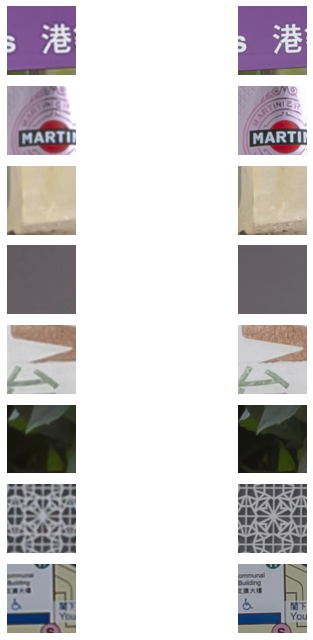

In [ ]:
%%time
data.show_batch(ds_type=DatasetType.Valid, rows=8, figsize=(9,9))

## create_learner


In [ ]:
learn_gen = create_learner(data, arch = models.resnet34, bottle=False, regularizations=False)

# Pokusy

In [ ]:
train_len = 1
print(f'Run experiment with limited RealSR dataset ({train_len} training images, no augmentations).')

gc.collect()

run_info = RunInfo('test', 'test', max_train_len=153, repeat_train=10, dihedral_augs=False)
run_experiment(run_info)

In [ ]:
%nbdev_export
def train_degradation_model(run_id='default'):
    run_experiment(run_id, dataset='realsr_inverse', repeat_train=10)
    

In [ ]:
import multiprocessing 

def _validate(model:nn.Module, dl:DataLoader, loss_func:OptLossFunc=None, cb_handler=None,
             pbar=None, average=True, n_batch:Optional[int]=None):
    "Calculate `loss_func` of `model` on `dl` in evaluation mode."
    print("_validate called")
    
    t = time.process_time()
    model.eval()
    #print(f"Time valid:model.eval(): {time.process_time() - t}")
    
    with torch.no_grad():
        val_losses,nums = [],[]
        
        t1 = time.process_time()
        if cb_handler: cb_handler.set_dl(dl)
        #print(f"Time valid:set_dl: {time.process_time() - t}")
        
        for xb,yb in dl:
            t = time.process_time()
            if cb_handler: xb, yb = cb_handler.on_batch_begin(xb, yb, train=False)
            #print(f"Time valid:on_batch_begin (xb, yb): {time.process_time() - t}")
            
            #t = time.process_time()
            val_loss = loss_batch(model, xb, yb, loss_func, cb_handler=cb_handler)
            print(f"Time valid:loss_batch + batch_begin: {time.process_time() - t}")
            
            t = time.process_time()
            
            val_losses.append(val_loss)
            if not is_listy(yb): yb = [yb]
            nums.append(first_el(yb).shape[0])
            
            
            if cb_handler and cb_handler.on_batch_end(val_losses[-1]): break
            print(f"Time valid:append_results + on_batch_end: {time.process_time() - t}")
            
            if n_batch and (len(nums)>=n_batch): break
                
        print(f"Time valid:total: {time.process_time() - t1}")
        nums = np.array(nums, dtype=np.float32)
        if average: return (to_np(torch.stack(val_losses)) * nums).sum() / nums.sum()
        else:       return val_losses

def _logged_fit(epochs:int, learn, callbacks:Optional[CallbackList]=None, metrics:OptMetrics=None)->None:
    "Fit the `model` on `data` and learn using `loss_func` and `opt`."
    assert len(learn.data.train_dl) != 0, f"""Your training dataloader is empty, can't train a model.
        Use a smaller batch size (batch size={learn.data.train_dl.batch_size} for {len(learn.data.train_dl.dataset)} elements)."""
    print("_logged_fit called")
    
    cb_handler = CallbackHandler(callbacks, metrics)
    pbar = master_bar(range(epochs))
    
    t = time.process_time()
    cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)
    print(f"Time on_train_begin: {time.process_time() - t}")
    
    exception=False
    try:
        for epoch in pbar:
            learn.model.train()
            cb_handler.set_dl(learn.data.train_dl)
            cb_handler.on_epoch_begin()
            tt = time.process_time()
            print(f"{len(multiprocessing.active_children())} processes")
            for xb,yb in learn.data.train_dl:
                
                t = time.process_time()
                xb, yb = cb_handler.on_batch_begin(xb, yb)
                #print(f"Time xb, yb: {time.process_time() - t}")

                #t = time.process_time()
                loss = loss_batch(learn.model, xb, yb, learn.loss_func, learn.opt, cb_handler)
                #print(f"Time loss_batch: {time.process_time() - t}")
                #t = time.process_time()
                if cb_handler.on_batch_end(loss): break
                print(f"Time train:on_batch_end: {time.process_time() - t}") 
                print(f"{len(multiprocessing.active_children())} processes")
                
            print(f"Time train:epoch_time: {time.process_time() - tt}")
            print(f"{len(multiprocessing.active_children())} processes")
            t = time.process_time()
            if not cb_handler.skip_validate and not learn.data.empty_val:
                print("Validate")
                val_loss = _validate(learn.model, learn.data.valid_dl, loss_func=learn.loss_func,
                                       cb_handler=cb_handler, pbar=pbar)
            else: val_loss=None
            print(f"Time val_loss: {time.process_time() - t}")    
            
            t = time.process_time()
            if cb_handler.on_epoch_end(val_loss): break
            print(f"Time on_epoch_end: {time.process_time() - t}")        
    except Exception as e:
        exception = e
        raise
    finally: cb_handler.on_train_end(exception)
        
def _fit(self, epochs:int, lr=defaults.lr,
            wd:Floats=None, callbacks:Collection[Callback]=None)->None:
        "Fit the model on this learner with `lr` learning rate, `wd` weight decay for `epochs` with `callbacks`."
        print("_fit called")
        lr = self.lr_range(lr)
        if wd is None: wd = self.wd
        if not getattr(self, 'opt', False): self.create_opt(lr, wd)
        else: self.opt.lr,self.opt.wd = lr,wd
        callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(callbacks)
        _logged_fit(epochs, self, metrics=self.metrics, callbacks=self.callbacks+callbacks)

In [ ]:
import types

learn_gen.fit = types.MethodType(_fit, learn_gen)


In [ ]:
learn_gen.metrics = []
learn_gen.callback_fns = []

In [ ]:
gen_name, path_logging, path_tensorboard, path_images = get_config(run_id)
learn_gen.data = data
learn_gen.fit_one_cycle(10, pct_start=0.3, callbacks=[])

16

Batches in epoch: 9
Total iters: 500000.0
Training will run for 55555 epochs.


epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,60.813324,59.875298,10.256034,0.107681,0.731566,1.123234,1.367783,1.698883,0.636624,00:24
1,60.592922,56.472031,13.053296,0.257964,0.477082,0.791120,1.299803,1.597010,0.666804,00:18


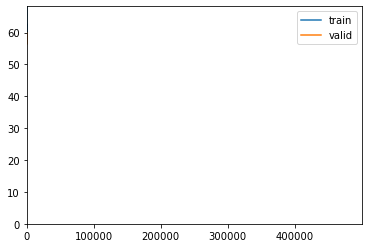

KeyboardInterrupt: 

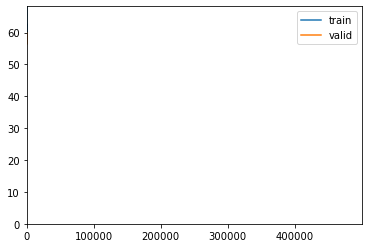

In [ ]:
gc.collect();
#test_run(learn_gen, epochs = 4)
train_model(run_id, learn_gen, pretraining=False)

# Export

In [ ]:
%nbdev_hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 0__template.ipynb.
Converted 10_data.ipynb.
Converted 11_div2k.ipynb.
Converted 12_realsr.ipynb.
Converted 20_metrics.ipynb.
Converted 21_loss.ipynb.
Converted 22_callbacks.ipynb.
Converted 23_tensorboard.ipynb.
Converted 31_generator_learner.ipynb.
Converted 32_critic_learner.ipynb.
Converted 41_generator_pretraining.ipynb.
Converted 42_critic_pretraining.ipynb.
Converted 43_gan_training.ipynb.
Converted EXPERIMENTS JOURNAL.ipynb.
Converted augmentations.ipynb.
Converted graphs-tests.ipynb.
Converted sr reference.ipynb.
